# Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import torch
torch.set_float32_matmul_precision('high')
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed
from utils.env import *
from utils.data import *
from train import *
device = torch.device('cpu') # faster than using GPU

# Experiment Settings
Settings are based on the training procedure that produced the RL agent experimental results in the paper.  
Original experiments were performed on a M1 iMac running MacOS Sonoma

In [2]:
seed = 96470
torch.manual_seed(seed)
set_random_seed(seed)

# GENERATOR
path = './runs/Jul02_17-23-02_aidf-svr-gpu03_rq_10/'
wgt_filename = 'generator.pt'

### Generator params

In [3]:
events_path = path
params = get_params_from_events(events_path)
for key, value in params.items():
    for key, value in value.items():
        if key in globals(): continue
        globals()[key] = value
data_params, model_params, train_params = get_params_dicts(vars().copy())

### RL Params

In [4]:
# ENV
n_training_steps = 1e7
env_params = {'interest_rate': 0.0,
              'transaction_cost': 0.0005,
              'max_long': 1.0,
              'max_short': -1.0,
              'trading_calendar': 'NYSE',
              'sample_len': 1300,
              'window_len': 50,
              'hist_len': 50,
              'n_periods': 1250}

# AGENT TYPE
policy_kwargs = dict(
    activation_fn=torch.nn.Tanh,
    net_arch=[64, 64, 32],
)
arguments = {
    'device': device,
    'gae_lambda': 0.9,
    'vf_coef': 1.0,
    'n_steps': 1250*50,
    'batch_size': 250,
    'learning_rate': 3e-5,
    'clip_range': 0.03,
    'policy_kwargs':policy_kwargs
}

### Get all objects

In [5]:
# get generator
generator = get_trained_generator(model_params, data_params, path, filename=wgt_filename, device=device)
df = pd.read_csv('./data/spx_20231229.csv', index_col=0, parse_dates=True)
path_generator = MA_path_generator(generator, df, '1995-01-01', '2022-10-19', ma_p, seed=seed)

# get env
env = get_rl_env(path_generator, env_params, seed=seed)
env.plot_episode_freq = 1000000

# get agent
agent = PPO('MlpPolicy', env, verbose=0, tensorboard_log='./runs', seed=seed, **arguments)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5855.98833716107
            Iterations: 37
            Function evaluations: 859
            Gradient evaluations: 37
                        Zero Mean - ARCH Model Results                        
Dep. Variable:           gaussianized   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5855.99
Distribution:                  Normal   AIC:                           11754.0
Method:            Maximum Likelihood   BIC:                           11897.9
                                        No. Observations:                 6999
Date:                Thu, Jul 04 2024   Df Residuals:                     6999
Time:                        16:26:34   Df Model:                            0
                               Volatility Model                              
  

/Users/luchungi/opt/anaconda3/envs/signature/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


# Training

In [6]:
agent.learn(n_training_steps)

E1 / S1250: Baseline Wealth = 2.0181 / Agent Final Wealth = 0.4852 / Average Weights and Std: [ 1.04493898 -0.04493898] / [0.73157287 0.73157287]
E2 / S2500: Baseline Wealth = 2.3377 / Agent Final Wealth = 0.6760 / Average Weights and Std: [ 1.05156277 -0.05156277] / [0.72372192 0.72372192]
E3 / S3750: Baseline Wealth = 1.8668 / Agent Final Wealth = 0.7049 / Average Weights and Std: [ 1.01885262 -0.01885262] / [0.71654906 0.71654906]
E4 / S5000: Baseline Wealth = 1.6684 / Agent Final Wealth = 0.5501 / Average Weights and Std: [0.99817788 0.00182212] / [0.73083581 0.73083581]
E5 / S6250: Baseline Wealth = 1.4080 / Agent Final Wealth = 0.6657 / Average Weights and Std: [9.99340097e-01 6.59902686e-04] / [0.70966087 0.70966087]
E6 / S7500: Baseline Wealth = 1.3801 / Agent Final Wealth = 0.6949 / Average Weights and Std: [ 1.02799748 -0.02799748] / [0.71732906 0.71732906]
E7 / S8750: Baseline Wealth = 1.8781 / Agent Final Wealth = 0.5240 / Average Weights and Std: [ 1.05901485 -0.05901485] 

# Evaluation

In [7]:
# get env
env_params['n_periods'] = len(df) - env_params['window_len']
env_params['stride'] = len(df)
spx_env = get_spx_data_env('./data/spx_20231229.csv', env_params)
evaluate_policy(agent, spx_env, n_eval_episodes=1, deterministic=True)

/Users/luchungi/opt/anaconda3/envs/signature/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/luchungi/opt/anaconda3/envs/signature/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Data period from 1995-01-03 to 2023-12-28 / Index: 0 to 7299
E1 / S7249: Baseline Wealth = 9.7047 / Agent Final Wealth = 15.5923 / Average Weights and Std: [0.16699403 0.83300597] / [0.43799588 0.43799588]
Not enough periods in real data for episode. Need 7299 but only have 0


(2.7467796407995717, 0.0)

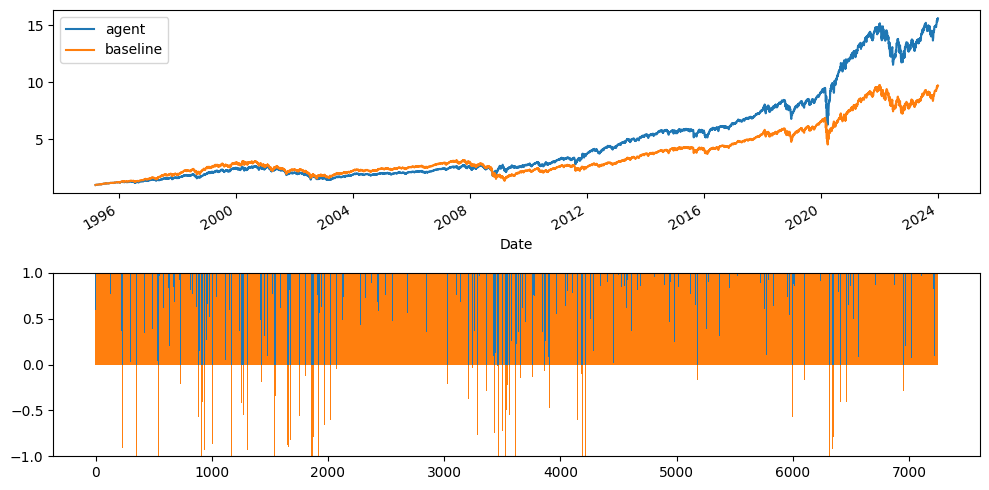

In [8]:
spx_env.plot()

In [3]:
csv_path = agent.logger.dir + '/data.csv'
df_spx = pd.read_csv(csv_path, index_col=0, parse_dates=True)

dates = [('1995-03-14', '2023-12-28'), ('2018-09-19', '2023-12-28'), ('2000-03-24', '2002-10-09'), ('2007-10-09', '2008-11-20'), ('2020-02-19', '2020-03-23')]
periods = ['Full dataset', 'Test period', 'Dot-com bubble burst', '2008 GFC', 'Covid']

table = perf_table(df_spx, dates, periods)
table

,Ann. return,Volatility,Sharpe ratio,Max drawdown
Full dataset,0.095474,0.179509,0.531937,-0.621196
Test period,0.117649,0.205392,0.573237,-0.414379
Dot-com bubble burst,-0.196418,0.214253,-0.918195,-0.600912
2008 GFC,-0.345945,0.334321,-1.038426,-0.426467
Covid,-4.350981,0.792123,-5.73163,-0.414379
